In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
import astropy.units as u
from astropy.io import fits
from astropy.time import Time
from astropy.coordinates import SkyCoord, get_body, Angle
from zodipy import Zodipy
import datetime
import os
import sys

In [3]:
model = Zodipy('dirbe')

wl = 3.4 << u.um

nside = 64

emission = model.get_emission_pix(
    wl,
    pixels = np.arange(hp.nside2npix(nside)),
    nside = nside,
    obs_time = Time(datetime.datetime.now().isoformat(), format='isot'),
    obs = 'earth',
    coord_in = 'E'  # ecliptic coordinates
)

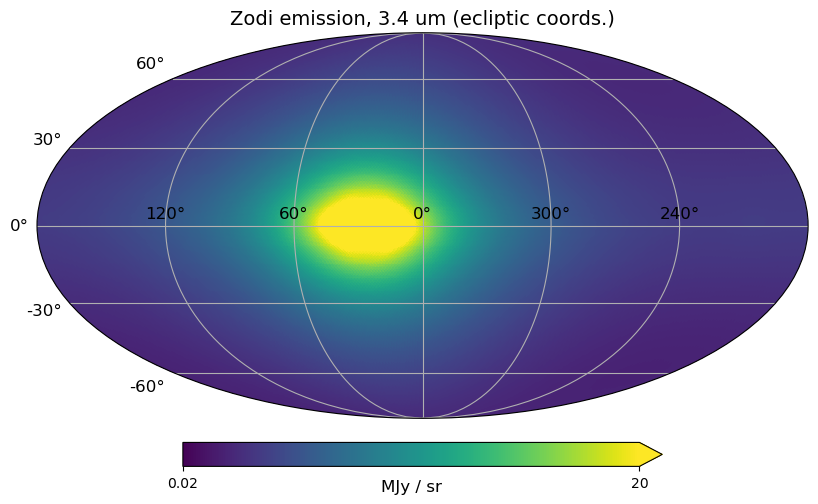

In [4]:
# plot
hp.projview(emission.value, unit=emission.unit, title=f'Zodi emission, {wl} (ecliptic coords.)', norm='log', min=.02, max=20,
            graticule=True, graticule_labels=True)

### full sky zodi map from $\varepsilon\sim90^\circ$

In [5]:
def get_solelons(obscrd, obstime, unit='deg'):
    """
    Return the angle between the observation LOS and the Sun, given input observation coordinate
    (~astropy.coordinates.SkyCoord) and observation time (~astropy.time.Time).
    """
    losuv = obscrd.geocentrictrueecliptic.cartesian
    obspos = get_body('earth', obstime).heliocentrictrueecliptic
    return Angle(np.arccos(losuv.dot(-obspos.cartesian) / obspos.distance)).to(unit)

In [6]:
# we want to get the above map, averaged throughout the year
def get_zodi_slice(obscrd, obstime, wl, min_epsilon, max_epsilon, nside=64):
    # get positions relative to the sun
    sol_elons = get_solelons(obscrd, obstime)
    # we want to take the zodi only in pixels ~90deg from the Sun
    #  (where WISE actually observes)
    observing_mask = (sol_elons > min_epsilon) & (sol_elons < max_epsilon)
    # get map (full sky)
    zodimap = np.full(hp.nside2npix(nside), np.nan)
    zodimap[observing_mask] = model.get_emission_pix(
        wl,
        pixels = np.arange(hp.nside2npix(nside)),
        nside = nside,
        obs_time = obstime,
        obs = 'earth',
        coord_in = 'E'  # ecliptic coordinates
    )[observing_mask]
    return zodimap

In [7]:
# INPUTS

# start and end obstimes
start_obstime = Time(datetime.datetime.now().isoformat(),
               format='isot', scale='utc')
end_obstime = start_obstime + datetime.timedelta(days=365)

# grid of obstimes
obstimes = np.linspace(start_obstime.jd, end_obstime.jd, 360)  # 360 to populate each degree on the sky

# coordinate of each healpixel
theta, phi = hp.pix2ang(nside,np.arange(hp.nside2npix(nside)))
lat = 90.0 - theta*180./np.pi
lon = phi * 180./np.pi
obscrd_hpx = SkyCoord(lon, lat, unit='deg', frame='geocentrictrueecliptic')

# range of elongation angles
min_epsilon = 85 << u.deg
max_epsilon = 95 << u.deg

# wavelengths
wl_w1 = 3.4 << u.um
wl_w2 = 4.6 << u.um
wl_min = 1.25 << u.um

In [8]:
# get maps at these obstimes, at the following epsilons:
maps = np.empty((len(obstimes), hp.nside2npix(nside)))
for i, obstime in enumerate(obstimes):
    print(f'{i+1} / {len(obstimes)}', end='\r')
    maps[i] = get_zodi_slice(obscrd_hpx, Time(obstime, format='jd'),
                                 wl=wl_w1,
                                 min_epsilon=min_epsilon,
                                 max_epsilon=max_epsilon)
# average these maps
avg_zodimap_w1 = np.nanmean(maps, axis=0)

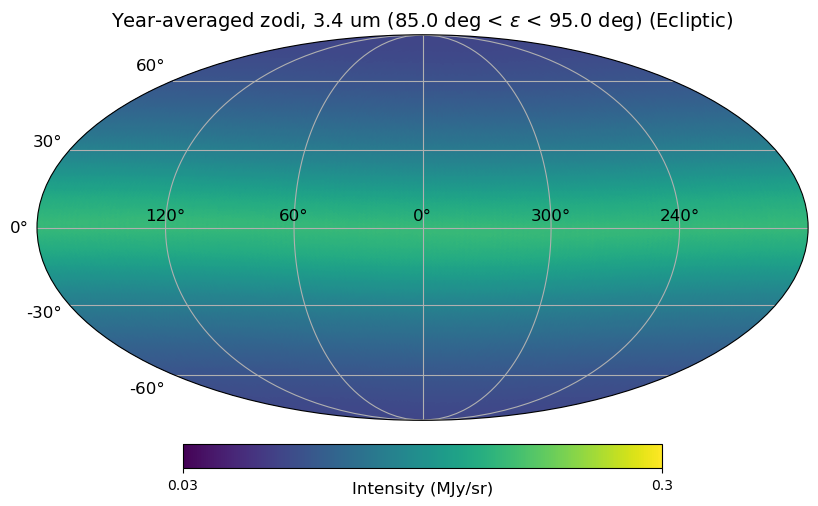

In [18]:
# plot
hp.projview(avg_zodimap_w1, min=3e-2, max=3e-1, norm='log', coord=['E'],
            unit=r'Intensity (MJy/sr)',
            title=f'Year-averaged zodi, {wl_w1} ({min_epsilon} < 'r'$\epsilon$ < 'f'{max_epsilon}) (Ecliptic)',
            graticule=True, graticule_labels=True)

In [10]:
# W2: get maps at these obstimes, at the following epsilons:
maps = np.empty((len(obstimes), hp.nside2npix(nside)))
for i, obstime in enumerate(obstimes):
    print(f'{i+1} / {len(obstimes)}', end='\r')
    maps[i] = get_zodi_slice(obscrd_hpx, Time(obstime, format='jd'),
                                 wl=wl_w2,
                                 min_epsilon=min_epsilon,
                                 max_epsilon=max_epsilon)
# average these maps
avg_zodimap_w2 = np.nanmean(maps, axis=0)

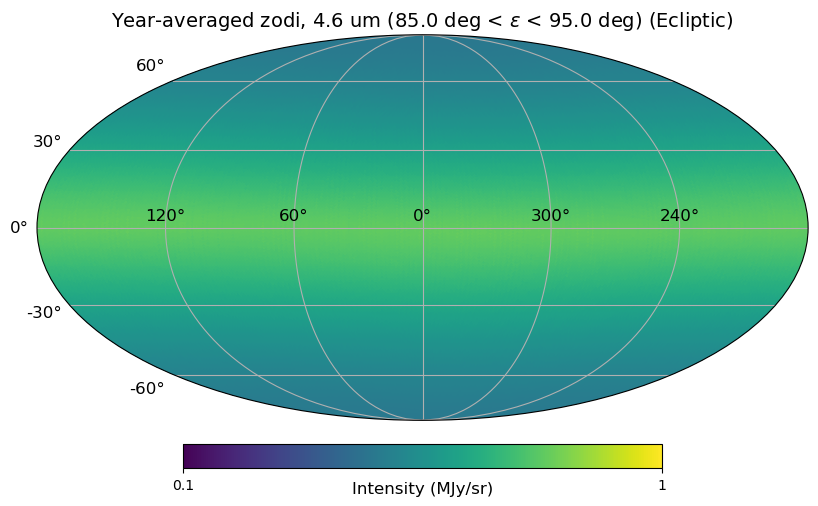

In [19]:
# plot
hp.projview(avg_zodimap_w2, min=1e-1, max=1, norm='log', coord=['E'],
            unit=r'Intensity (MJy/sr)',
            title=f'Year-averaged zodi, {wl_w2} ({min_epsilon} < 'r'$\epsilon$ < 'f'{max_epsilon}) (Ecliptic)',
            graticule=True, graticule_labels=True)

In [12]:
# minimum wavelength available in ZodiPy: get maps at these obstimes, at the following epsilons:
maps = np.empty((len(obstimes), hp.nside2npix(nside)))
for i, obstime in enumerate(obstimes):
    print(f'{i+1} / {len(obstimes)}', end='\r')
    maps[i] = get_zodi_slice(obscrd_hpx, Time(obstime, format='jd'),
                                 wl=wl_min,
                                 min_epsilon=min_epsilon,
                                 max_epsilon=max_epsilon)
# average these maps
avg_zodimap_min = np.nanmean(maps, axis=0)

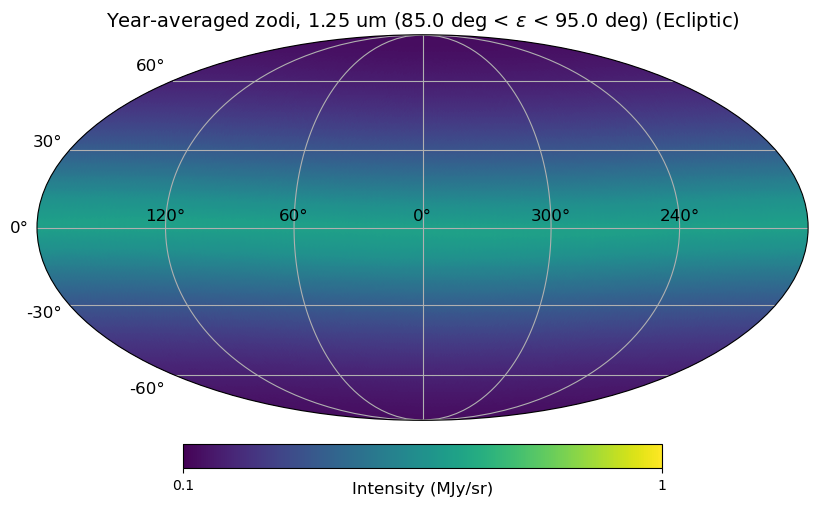

In [22]:
# plot
hp.projview(avg_zodimap_min, min=1e-1, max=1, norm='log', coord=['E'],
            unit=r'Intensity (MJy/sr)',
            title=f'Year-averaged zodi, {wl_min} ({min_epsilon} < 'r'$\epsilon$ < 'f'{max_epsilon}) (Ecliptic)',
            graticule=True, graticule_labels=True)

Text(0.5, 0.98, 'Year-averaged zodi (85.0 deg < $\\epsilon$ < 95.0 deg) (Ecliptic coords.)')

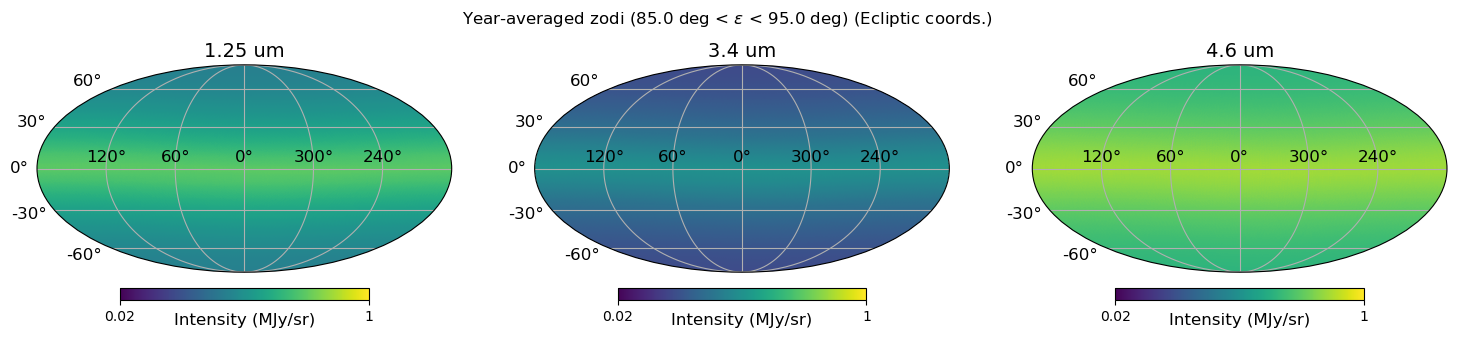

In [48]:
# plot all three with the same color scale
fig = plt.figure(figsize=(15,3.5))
kwargs = dict(min=2e-2, max=1e0, coord=['E'], norm='log', unit=r'Intensity (MJy/sr)',
              graticule=True, graticule_labels=True)
hp.projview(avg_zodimap_min, title=wl_min, sub=(1,3,1), **kwargs)
hp.projview(avg_zodimap_w1, title=wl_w1, sub=(1,3,2), **kwargs)
hp.projview(avg_zodimap_w2, title=wl_w2, sub=(1,3,3), **kwargs)
fig.suptitle(f'Year-averaged zodi ({min_epsilon} < 'r'$\epsilon$ < 'f'{max_epsilon}) (Ecliptic coords.)')

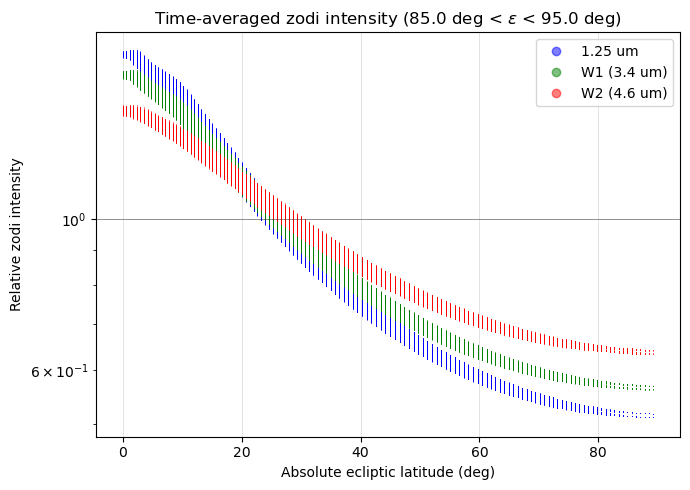

In [44]:
# BRIGHTNESS AS A FUNCTION OF ECLIPTIC LATITUDE
# mean-normalize
avg_zodimap_min_ = avg_zodimap_min / np.mean(avg_zodimap_min)
avg_zodimap_w1_ = avg_zodimap_w1 / np.mean(avg_zodimap_w1)
avg_zodimap_w2_ = avg_zodimap_w2 / np.mean(avg_zodimap_w2)

zodimaps = [avg_zodimap_min_, avg_zodimap_w1_, avg_zodimap_w2_]
colors = ['b', 'g', 'r']
labels = [wl_min, f'W1 ({wl_w1})', f'W2 ({wl_w2})' ]
legend_elements = []

# fit a slope to absolute latitude for each of these, and plot
elat = obscrd_hpx.geocentrictrueecliptic.lat.deg
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

for i, zodimap in enumerate(zodimaps):

    p = np.polyfit(np.abs(elat), zodimap, deg=1)
    kwargs = dict(c=colors[i], alpha=0.5, ls='None')
    # ax.plot(np.abs(elat), np.abs(elat) * p[0] + p[1], c='b', label=f'{wl_bp}: y={p[0]:.3f}x+{p[1]:.1f}')
    ax.plot(np.abs(elat), zodimap, marker=',', **kwargs)
    legend_elements.append(mpl.lines.Line2D([0], [0], marker='o', label=labels[i], **kwargs))

ax.semilogy()
ax.axhline(1., c='k', alpha=0.5, lw=0.5)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel('Absolute ecliptic latitude (deg)')
ax.set_ylabel('Relative zodi intensity')
ax.set_title(f'Time-averaged zodi intensity ({min_epsilon} < 'r'$\epsilon$ < 'f'{max_epsilon})')
ax.legend(handles=legend_elements)

In [38]:
# save maps
wls = [wl_min, wl_w1, wl_w2]
save_fns = [
    os.path.join('/scratch/aew492/quasars/maps/zodi', f'zodimap_90degfromSun_oneyear_{wl.value:.1f}{wl.unit}.fits') for wl in wls
]
for i, zodimap in enumerate(zodimaps):
    hdu = fits.PrimaryHDU()
    hdu.data = zodimap
    hdu.header['UNIT'] = ('MJy / sr', 'Zodi intensity unit')
    hdu.header['WL'] = (wls[i].value, f'Observation wavelength ({wls[i].unit})')
    hdu.header['MINEPS'] = (min_epsilon.value, f'Min. solar elongation angle observed ({min_epsilon.unit})')
    hdu.header['MAXEPS'] = (max_epsilon.value, f'Max. solar elongation angle observed ({min_epsilon.unit})')
    hdu.header['NSIDE'] = (nside, 'Healpix resolution (NSIDE)')
    hdu.header['MODEL'] = ('Dirbe', 'ZodiPy model')
    hdu.header['COORD'] = ('geometrictrueecliptic', 'Sky coordinate system')
    hdu.header['COMMENT'] = 'Zodi intensity averaged over one year (360 observations)'
    hdu.writeto(save_fns[i])